In [1]:
!nvidia-smi

Fri Dec 15 07:24:29 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           On  | 00000000:15:00.0 Off |                    0 |
| N/A   27C    P0              40W / 300W |      0MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Packages

In [2]:
import os
import sys
sys.path.append("../src")

In [3]:
%load_ext autoreload
%autoreload 2

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [33]:
from einops import repeat, rearrange, reduce

import math

import lightning.pytorch as pl

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

In [38]:
import config
from dataloader import BEDataset, BEDataModule

from rt1 import RT1Encoder, RT1Decoder, RT1CRAM
# from rnn_decoder import AttentionModule, RNNDecoder
from utils.model_utils import TextEncoder, fetch_sample_from_batch, plot_attention, get_seq_len


## Data module

In [6]:
dm = BEDataModule()
dm.setup()

INFO:root:Training on 3808 samples.
INFO:root:Validating on 700 samples.
INFO:root:Testing on 250 samples.


Total # examples: 4758


In [7]:
%%time
batch = next(iter(dm.train_dataloader()))
print(batch.keys())
batch["in_state"].shape

/ocean/projects/cis230036p/cmanouan/miniconda3/envs/smf_be/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


dict_keys(['sample_id', 'in_state', 'action_desc', 'motor_cmd'])
CPU times: user 602 ms, sys: 646 ms, total: 1.25 s
Wall time: 22.6 s


torch.Size([32, 3, 288, 288])

In [8]:
input_ids=batch["action_desc"]["ids"].cuda()
attn_mask=batch["action_desc"]["mask"].cuda()
token_type_ids=batch["action_desc"]["token_type_ids"].cuda()
imgs=batch["in_state"].cuda()
decoder_inp=batch["motor_cmd"]["decoder_inp_ids"].cuda()

decoder_inp.shape

torch.Size([32, 16])

## Encoder

In [9]:
encoder = RT1Encoder(
    cnn_bacnbone="resnet18", 
    num_res_blocks=3, 
    freeze_cnn_backbone=True
).to(config.DEVICE)

summary(model=encoder, col_names=["num_params", "trainable"])

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
INFO:timm.models._hub:[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


Layer (type:depth-idx)                                       Param #                   Trainable
RT1Encoder                                                   --                        Partial
├─TextEncoder: 1-1                                           --                        False
│    └─BertModel: 2-1                                        --                        False
│    │    └─BertEmbeddings: 3-1                              (15,891,456)              False
│    │    └─BertEncoder: 3-2                                 (12,609,536)              False
│    │    └─BertPooler: 3-3                                  (262,656)                 False
│    └─Dropout: 2-2                                          --                        --
├─FiLMEncoder: 1-2                                           --                        Partial
│    └─ImageFeatureExtractor: 2-3                            --                        Partial
│    │    └─FeatureListNet: 3-4                              (1

In [10]:
text_enc_h_state, learned_tokens, _ = encoder(
    input_ids=input_ids,
    attn_mask=attn_mask,
    token_type_ids=token_type_ids,
    imgs=imgs
)

learned_tokens.shape, text_enc_h_state.shape

(torch.Size([32, 48, 512]), torch.Size([32, 16, 512]))

In [11]:
pooled = reduce(learned_tokens, 'b (f n) d -> b n d', 'mean', f = 6)

pooled.shape

torch.Size([32, 8, 512])

## Decoder

### Attention module

In [ ]:
class AttentionModule(torch.nn.Module):
    def __init__(self, listener_hidden_size, speller_output_size, projection_size):
        super().__init__()

        self.projection_size    = projection_size

        self.key_projection     = torch.nn.Linear(listener_hidden_size*2, projection_size)
        self.value_projection   = torch.nn.Linear(listener_hidden_size*2, projection_size)
        self.query_projection   = torch.nn.Linear(speller_output_size, projection_size) # because final LSTM Cell has key_value_size output
        #self.context_projection = torch.nn.Linear(speller_output_size, projection_size)
        self.softmax            = torch.nn.Softmax(dim= 1)
  
    def set_key_value(self, encoder_outputs):
        self.key    = self.key_projection(encoder_outputs)
        self.value  = self.value_projection(encoder_outputs)
       
    def compute_context(self, decoder_context):
        
        self.query          = self.query_projection(decoder_context)
        raw_weights         = torch.bmm(self.key, self.query.unsqueeze(2)).squeeze(2) # energy dim (B, T)

        attention_weights   = self.softmax(raw_weights/np.sqrt(self.projection_size))
        attention_context   = torch.bmm(attention_weights.unsqueeze(1), self.value).squeeze(1)

        return attention_context, attention_weights

### RNN Decoder

In [ ]:
class RNNDecoder(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 embedding_size,
                 speller_hidden_size,
                 speller_output_size, 
                 speller_lstm_cells,
                 attender:Attention):
        super().__init__()

        self.attention_module         = attender # Attention object in speller
        self.max_timesteps  = config.

        self.embedding      = torch.nn.Embedding(vocab_size, embedding_size, padding_idx= PAD_TOKEN)
        self.emb_dropout    = torch.nn.Dropout(p= config['speller']['embedding_dp'])
        
        self.lstm_cells     = MyLSTMCell(
            input_size      = embedding_size+attender.projection_size,
            hidden_size     = speller_hidden_size,
            output_size     = speller_output_size,
            num_layers      = speller_lstm_cells,
            dropout         = 0.3
        )
        self.gumbel_softmax = LearnableGumbelSoftmax()
        
        # For CDN (Feel free to change)
        #self.CDN_dropout        = torch.nn.Dropout(config['speller']['lstm_dp']/2)
        self.char_prob          = torch.nn.Linear(attender.projection_size+speller_output_size, vocab_size)
        self.char_prob.weight   = self.embedding.weight
        # Weight tying (From embedding layer)

    
    def CDN(self, output_context):
        output_char_dist    = self.char_prob(output_context)
        return output_char_dist
    
    def forward(self, y= None, teacher_forcing_ratio=1):

        batch_size, input_timesteps, _  = self.attention_module.key.shape

        attention_context   = torch.zeros((batch_size, self.attention_module.projection_size)).to(DEVICE)
        output_symbol       = torch.full((batch_size, ), fill_value= SOS_TOKEN).to(DEVICE)
        raw_outputs         = []  
        attention_plot      = []

        if y is None:
            timesteps               = self.max_timesteps
            teacher_forcing_ratio   = 0 #Why does it become zero?

        else:
            timesteps           = y.shape[1] # How many timesteps are we predicting for?
            #label_embeddings    = self.embedding(y)

        hidden_states   = [None]*len(self.lstm_cells)

        for t in range(timesteps):
            p = np.random.random_sample()

            if p < teacher_forcing_ratio and t > 0:
                output_symbol = y[:,t-1]

            char_embed      = self.embedding(output_symbol)
            char_embed      = self.emb_dropout(char_embed)

            lstm_input      = torch.cat([char_embed, attention_context], dim=1)

            lstm_output, hidden_states = self.lstm_cells(lstm_input, hidden_states) # Feed the input through LSTM Cells and attention.
      
            # What should we retrieve from forward_step to prepare for the next timestep?
            attn_context, attn_weights = self.attention_module.compute_context(lstm_output) # Feed the resulting hidden state into attention

            final_context   = torch.cat([self.attention_module.query, attn_context], dim=1)
            raw_pred        = self.CDN(final_context)

            # Generate a prediction for this timestep and collect it in output_symbols
            raw_pred        = self.gumbel_softmax(raw_pred)
            output_symbol   = raw_pred.argmax(dim= 1)

            raw_outputs.append(raw_pred) # for loss calculation
            attention_plot.append(attn_weights) # for plottingn attention plot

        attention_plot  = torch.stack(attention_plot, dim=1)
        raw_outputs     = torch.stack(raw_outputs, dim=1)

        return raw_outputs, attention_plot

### Test decoder Layer

In [12]:
# dec_layer = DecoderLayer().cuda()
# print(dec_layer)
# summary(dec_layer)

In [13]:
target_embedding = EmbeddingLayer().cuda()

outp = decoder_inp
outp_emb = target_embedding(outp)

outp_emb.shape

torch.Size([32, 16, 512])

In [14]:
# seq_len = get_seq_len(outp[0])

# # outp[0], seq_laen 

In [15]:
# attn_mask = make_attn_mask()

# attn_mask.float()

In [16]:
# dec_out, self_attn_w, cross_attn_w = dec_layer(
#     dec_in=outp_emb, 
#     enc_out=learned_tokens
# )

# dec_out.shape, self_attn_w.shape, cross_attn_w.shape

In [17]:
# plot_attention(self_attn_w)

In [18]:
# plot_attention(cross_attn_w)

### Test decoder 

In [19]:
dec = TransformerDecoder(num_layers=1).cuda()
print(dec)
summary(model=dec)

TransformerDecoder(
  (emb_layer): EmbeddingLayer(
    (tok_emb): Embedding(52, 512, padding_idx=0)
    (pos_emb): PositionalEncoding()
    (drop_out): Dropout(p=0.2, inplace=False)
  )
  (layers): ModuleList(
    (0): DecoderLayer(
      (self_attention): MultiHeadAttention(
        (attention): ScaleDotProductAttention(
          (softmax): Softmax(dim=-1)
        )
        (w_q): Linear(in_features=512, out_features=512, bias=True)
        (w_k): Linear(in_features=512, out_features=512, bias=True)
        (w_v): Linear(in_features=512, out_features=512, bias=True)
        (w_concat): Linear(in_features=512, out_features=512, bias=True)
      )
      (norm1): LayerNorm()
      (dropout1): Dropout(p=0.2, inplace=False)
      (cross_attention): MultiHeadAttention(
        (attention): ScaleDotProductAttention(
          (softmax): Softmax(dim=-1)
        )
        (w_q): Linear(in_features=512, out_features=512, bias=True)
        (w_k): Linear(in_features=512, out_features=512, bias=

Layer (type:depth-idx)                             Param #
TransformerDecoder                                 --
├─EmbeddingLayer: 1-1                              --
│    └─Embedding: 2-1                              26,624
│    └─PositionalEncoding: 2-2                     --
│    └─Dropout: 2-3                                --
├─ModuleList: 1-2                                  --
│    └─DecoderLayer: 2-4                           --
│    │    └─MultiHeadAttention: 3-1                1,050,624
│    │    └─LayerNorm: 3-2                         1,024
│    │    └─Dropout: 3-3                           --
│    │    └─MultiHeadAttention: 3-4                1,050,624
│    │    └─LayerNorm: 3-5                         1,024
│    │    └─Dropout: 3-6                           --
│    │    └─FeedForwardLayer: 3-7                  1,050,112
│    │    └─LayerNorm: 3-8                         1,024
│    │    └─Dropout: 3-9                           --
Total params: 3,181,056
Trainable params: 3

In [20]:
dec_out, self_attn_w, cross_attn_w = dec(
    dec_in=outp, 
    enc_out=learned_tokens
)

dec_out.shape, self_attn_w.shape, cross_attn_w.shape

(torch.Size([32, 16, 512]),
 torch.Size([32, 8, 16, 16]),
 torch.Size([32, 8, 16, 48]))

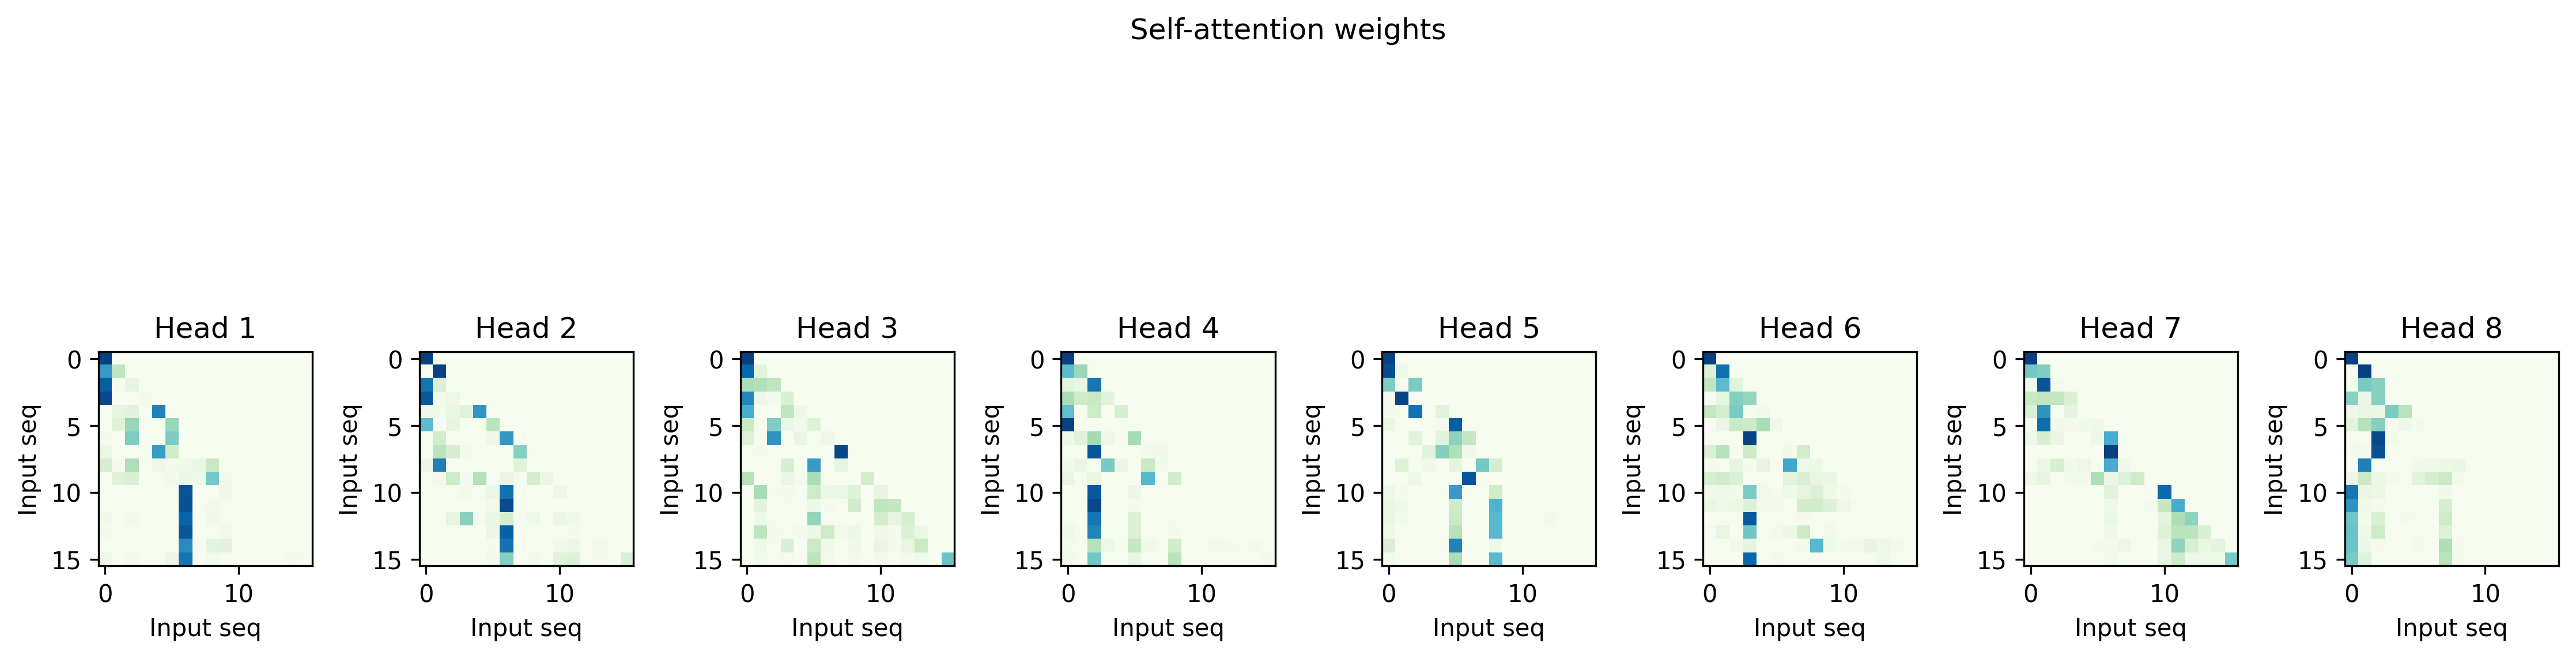

In [21]:
plot_attention(self_attn_w)

In [22]:
self_attn_w[0, 0, 4]

tensor([3.0791e-04, 9.7101e-02, 1.1763e-01, 3.7046e-04, 7.8459e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)

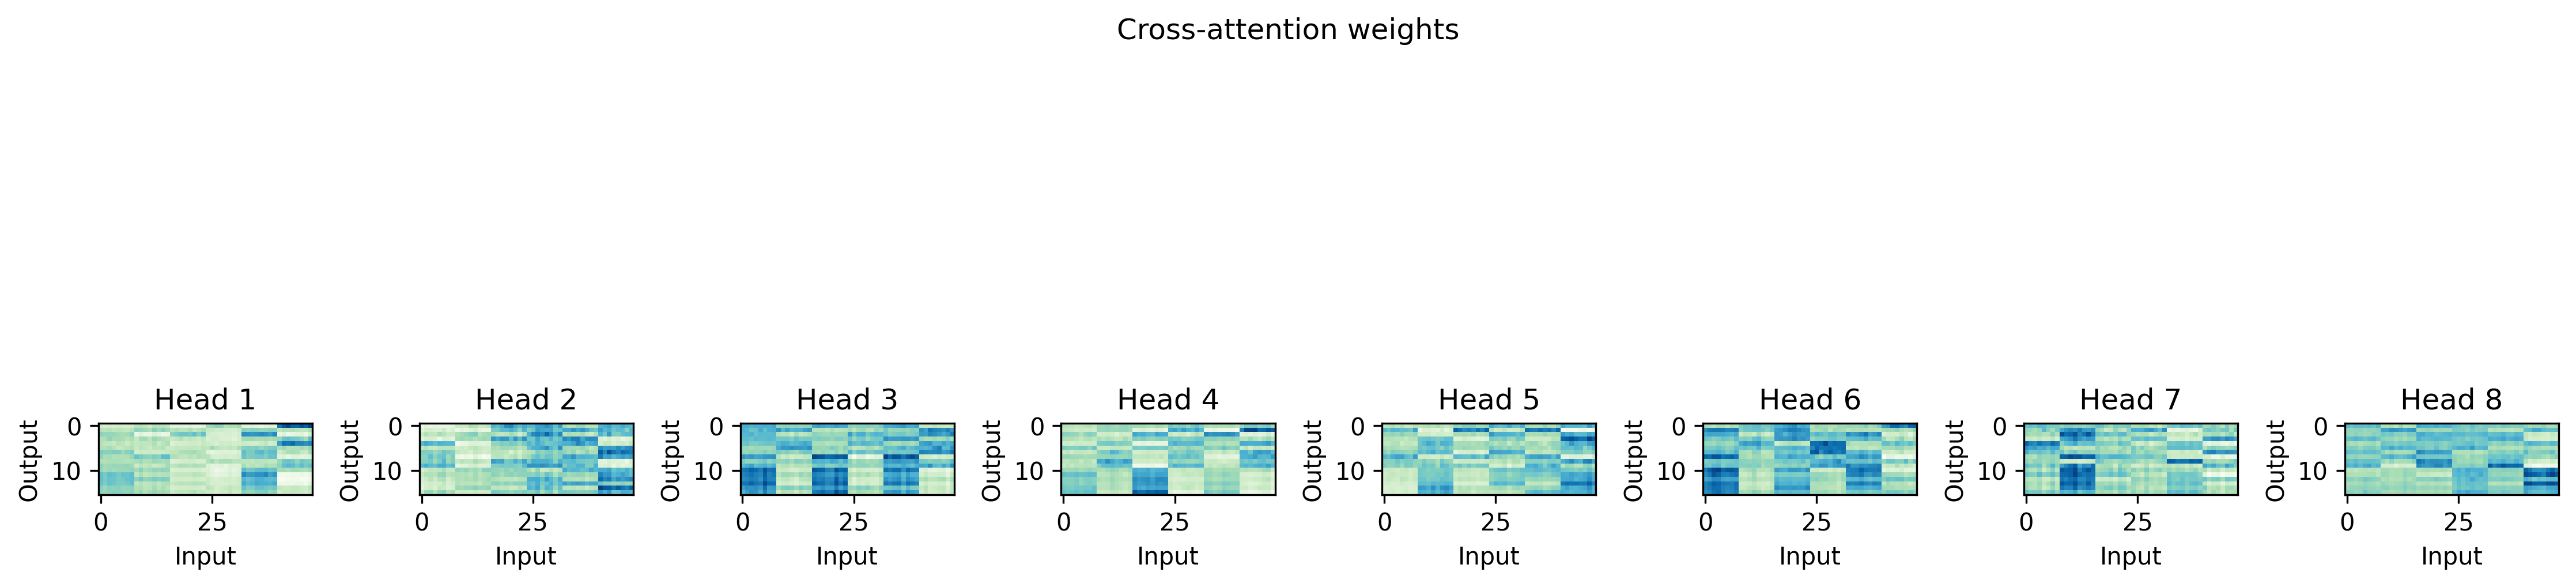

In [23]:
plot_attention(cross_attn_w)

## RT1 Decoder

In [26]:
decoder = RT1Decoder().cuda()
print(decoder)
summary(decoder)

RT1Decoder(
  (transformer): TransformerDecoder(
    (emb_layer): EmbeddingLayer(
      (tok_emb): Embedding(52, 512, padding_idx=0)
      (pos_emb): PositionalEncoding()
      (drop_out): Dropout(p=0.2, inplace=False)
    )
    (layers): ModuleList(
      (0): DecoderLayer(
        (self_attention): MultiHeadAttention(
          (attention): ScaleDotProductAttention(
            (softmax): Softmax(dim=-1)
          )
          (w_q): Linear(in_features=512, out_features=512, bias=True)
          (w_k): Linear(in_features=512, out_features=512, bias=True)
          (w_v): Linear(in_features=512, out_features=512, bias=True)
          (w_concat): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNorm()
        (dropout1): Dropout(p=0.2, inplace=False)
        (cross_attention): MultiHeadAttention(
          (attention): ScaleDotProductAttention(
            (softmax): Softmax(dim=-1)
          )
          (w_q): Linear(in_features=512, out_features=512

Layer (type:depth-idx)                                  Param #
RT1Decoder                                              --
├─TransformerDecoder: 1-1                               --
│    └─EmbeddingLayer: 2-1                              26,624
│    │    └─Embedding: 3-1                              26,624
│    │    └─PositionalEncoding: 3-2                     --
│    │    └─Dropout: 3-3                                --
│    └─ModuleList: 2-2                                  --
│    │    └─DecoderLayer: 3-4                           3,154,432
├─LayerNorm: 1-2                                        1,024
├─ActionGenerator: 1-3                                  --
│    └─Sequential: 2-3                                  --
│    │    └─Linear: 3-5                                 26,676
│    │    └─Dropout: 3-6                                --
Total params: 3,235,380
Trainable params: 3,235,380
Non-trainable params: 0

In [79]:
dec_out, self_attn_w, cross_attn_w = decoder(
    inp=outp, 
    encoder_out=learned_tokens
)

dec_out.shape, self_attn_w.shape, cross_attn_w.shape

score:  torch.Size([32, 8, 16, 16])
attn_w:  torch.Size([32, 8, 16, 16])
context:  torch.Size([32, 8, 16, 64])
score:  torch.Size([32, 8, 16, 48])
attn_w:  torch.Size([32, 8, 16, 48])
context:  torch.Size([32, 8, 16, 64])


(torch.Size([32, 16, 52]),
 torch.Size([32, 8, 16, 16]),
 torch.Size([32, 8, 16, 48]))

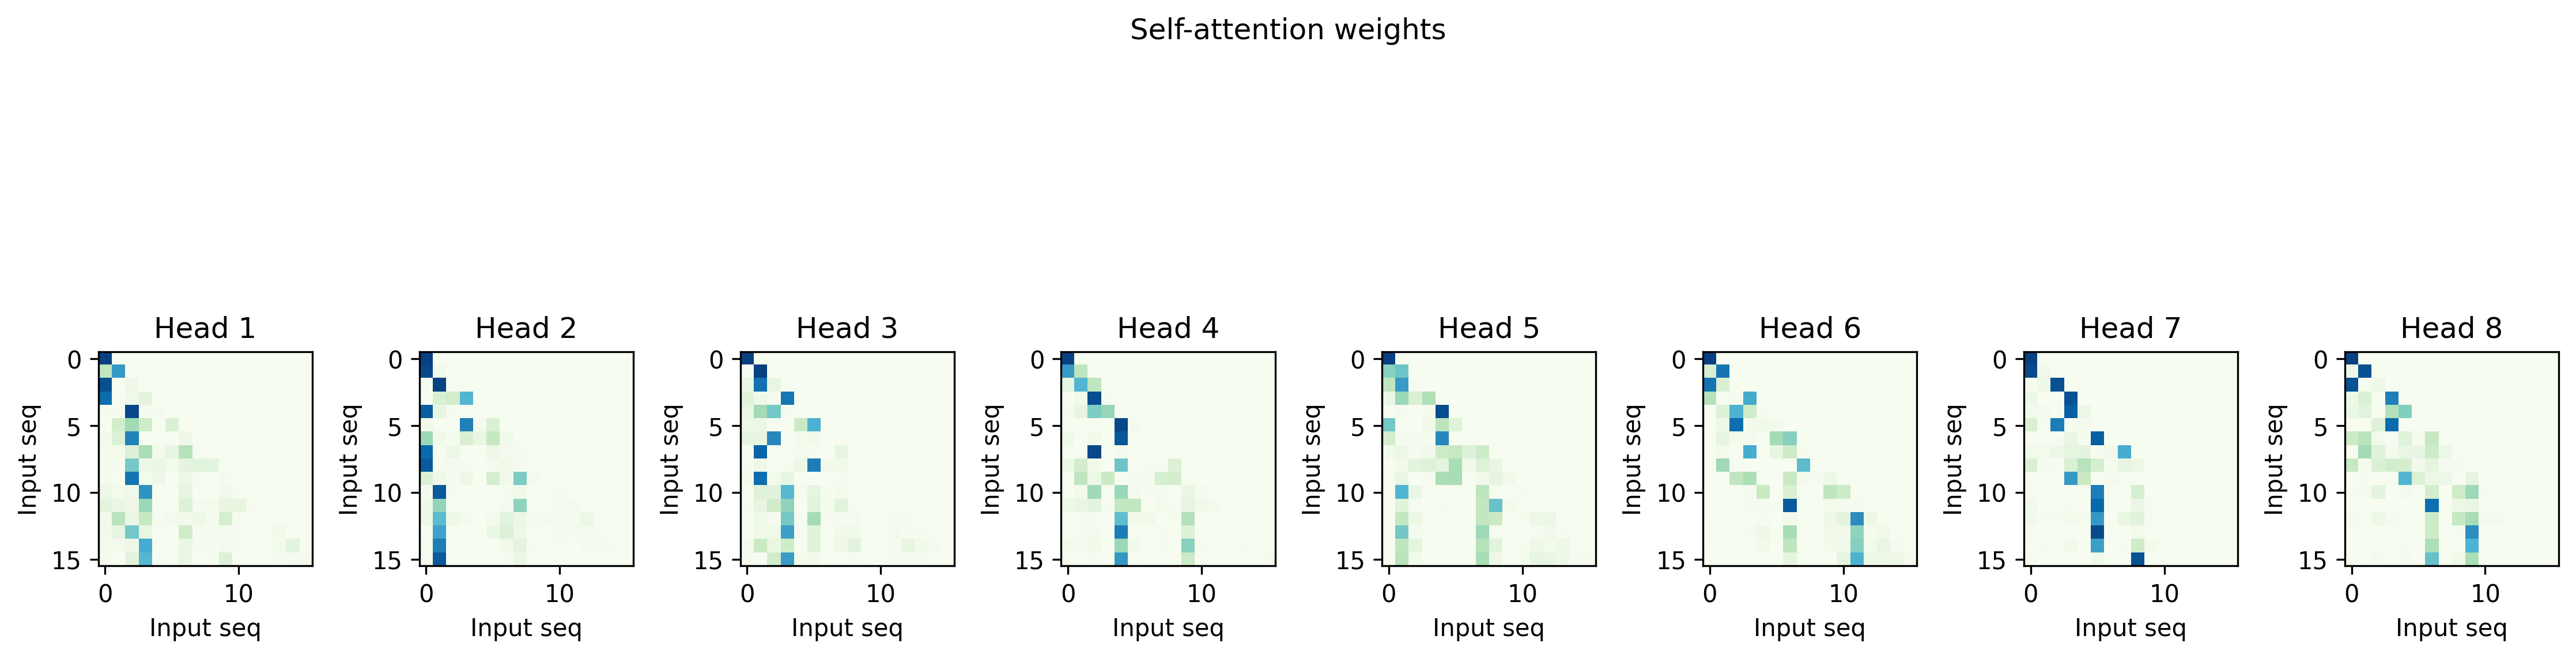

In [80]:
plot_attention(self_attn_w)

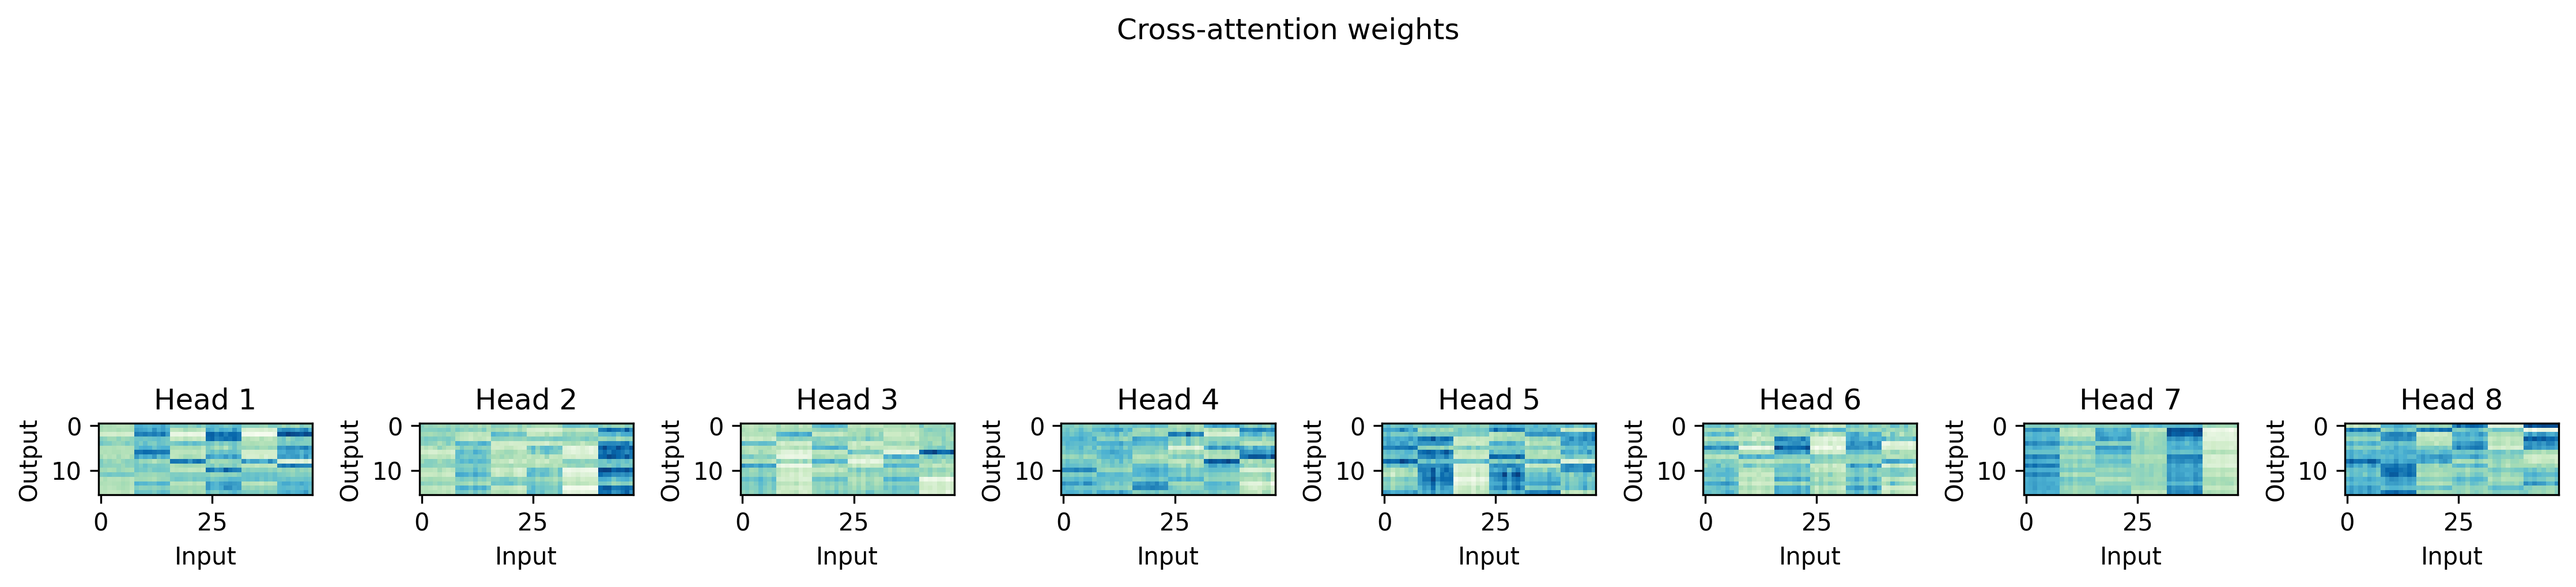

In [81]:
plot_attention(cross_attn_w)

## Decoding scheme

In [131]:
def greedy_decoding(
    model:pl.LightningModule, 
    batch_inp:dict, 
    max_len:int=config.MAX_OUT_SEQ_LEN, 
    debug:bool=False
):
    if model.device.type == "cpu":
        model.to(config.DEVICE)
    model.eval()
    
    sos_token = config.TARGETS_MAPPING["[SOS]"]
    eos_token = config.TARGETS_MAPPING["[EOS]"]
    
    input_ids=batch_inp["ids"].to(config.DEVICE)
    attn_mask=batch_inp["mask"].to(config.DEVICE)
    token_type_ids=batch_inp["token_type_ids"].to(config.DEVICE)
    imgs=batch_inp["in_state"].to(config.DEVICE)

    _, learned_tokens = model._encode(
        input_ids=input_ids, 
        attn_mask=attn_mask, 
        token_type_ids=token_type_ids, 
        imgs=imgs    
    )
    
    decoder_inp = torch.empty(1, 1, dtype=torch.long, device=input_ids.device).fill_(sos_token)

    for t in range(config.MAX_OUT_SEQ_LEN):
        mask = make_attn_mask(dim=decoder_inp.shape[1])

        with torch.no_grad():
            logits, self_attn_ws, cross_attn_ws = rt1._decode(
            decoder_inp=decoder_inp, 
            encoder_out=learned_tokens,
            attn_mask=mask
        )

        # perform greedy decoding
        probs = rt1.decoder.action_generator(logits[:, -1])

        _, next_tok = torch.max(probs, dim=-1)
        # update decoder input
        decoder_inp = torch.cat((decoder_inp, next_tok.unsqueeze(1)), dim=1)
            
    return decoder_inp[:, 1:].cpu().detach(), logits, self_attn_ws.cpu().detach(), cross_attn_ws.cpu().detach()

In [88]:
rt1 = RT1CRAM(
    cnn_bacnbone=config.SELECTED_CNN_BACKBONE, 
    num_res_blocks=config.NUM_RES_BLOCKS,
    freeze_cnn_backbone=config.FREEZE_CNN
).cuda()

summary(rt1)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet34.a1_in1k)
INFO:timm.models._hub:[timm/resnet34.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


Layer (type:depth-idx)                                            Param #
RT1CRAM                                                           --
├─RT1Encoder: 1-1                                                 --
│    └─TextEncoder: 2-1                                           --
│    │    └─BertModel: 3-1                                        (28,763,648)
│    │    └─Dropout: 3-2                                          --
│    └─FiLMEncoder: 2-2                                           --
│    │    └─ImageFeatureExtractor: 3-3                            21,547,328
│    │    └─ModuleList: 3-4                                       4,227,072
│    └─TokenLearnerV11: 2-3                                       --
│    │    └─Sequential: 3-5                                       134,408
├─RT1Decoder: 1-2                                                 --
│    └─TransformerDecoder: 2-4                                    --
│    │    └─EmbeddingLayer: 3-6                                   53

In [132]:
in_batch = fetch_sample_from_batch(
    batch, 
    batch_size=batch["in_state"].shape[0],
    random=True
)

In [141]:
%%time

pred_ids, logits, self_attn_ws, cross_attn_ws = greedy_decoding(
    model=rt1, 
    batch_inp=in_batch, 
    debug=False
)

pred_ids.shape

CPU times: user 143 ms, sys: 957 µs, total: 144 ms
Wall time: 145 ms


torch.Size([1, 16])

In [142]:
print(pred_ids)
rt1.decode_predictions(predicted_ids=decoder_inp)

tensor([[ 2, 10, 41, 17, 47, 18, 48, 15, 46, 46, 46, 46, 46, 18, 51, 46]])


["[SOS] RED #'*on-transformation* POSE-6 :MONDAMIN #'*rightward-transformation* #'*forward-transformation* :RED-METAL-PLATE NIL :MONDAMIN #'*rightward-transformation* POSE-6 :BOTTLE RED BLUE :CUBE :POT"]

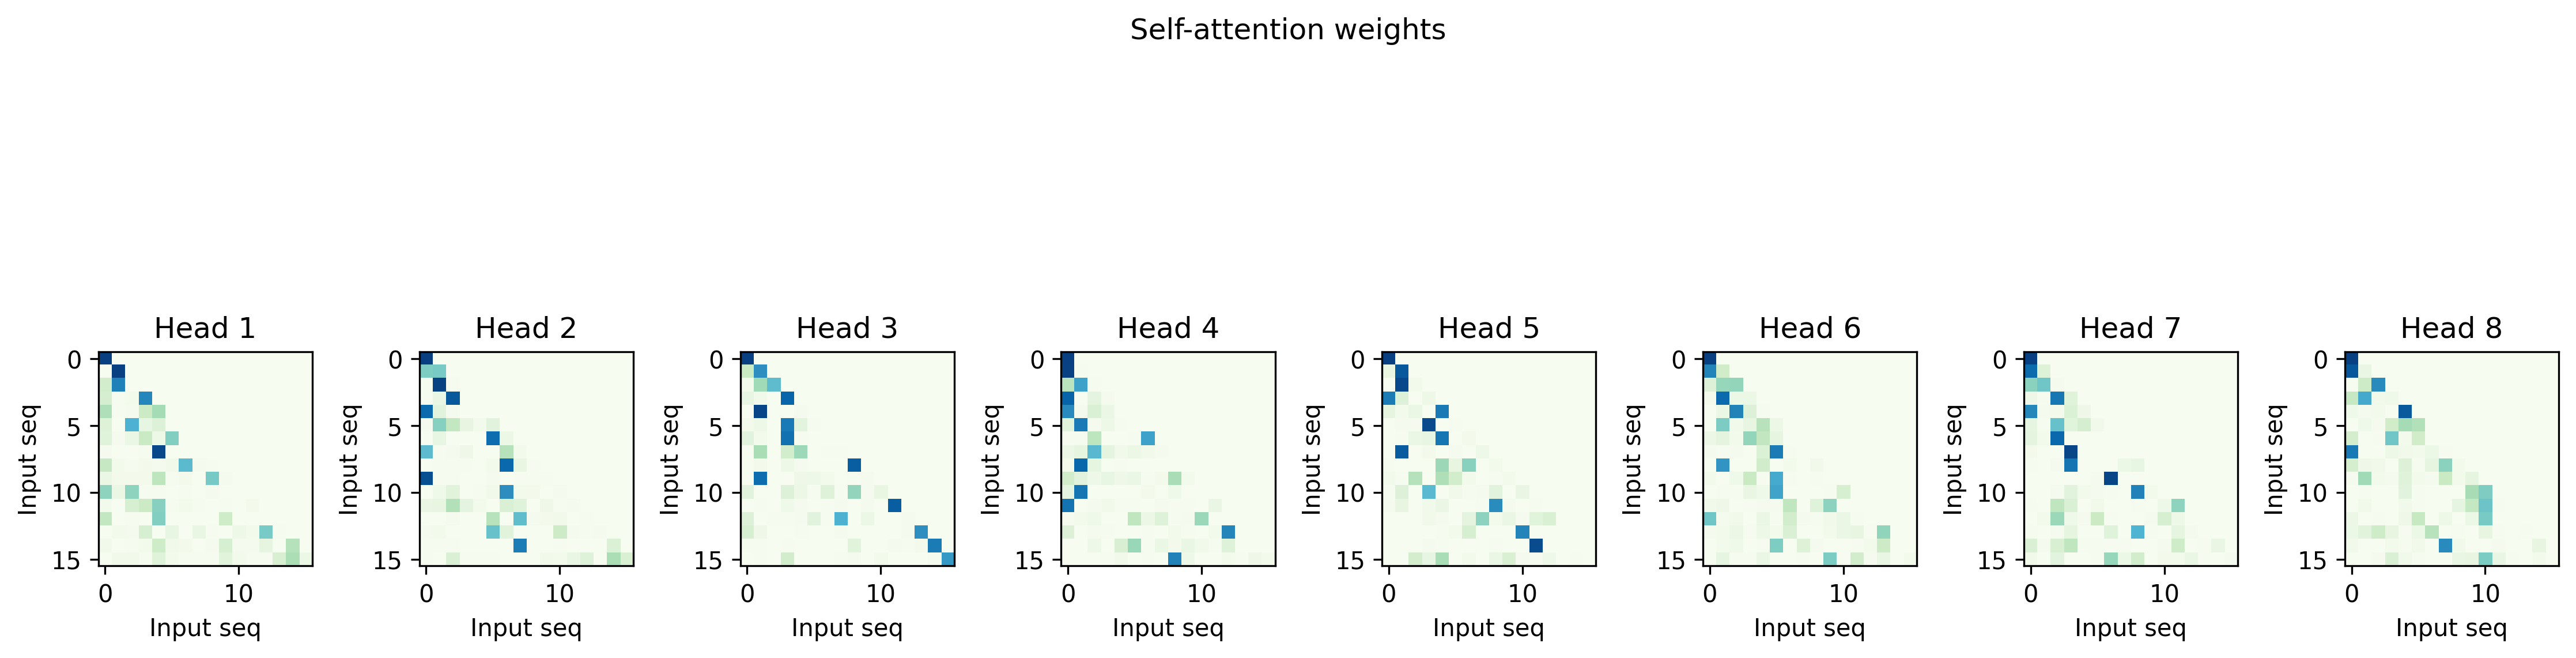

In [130]:
plot_attention(self_attn_ws)

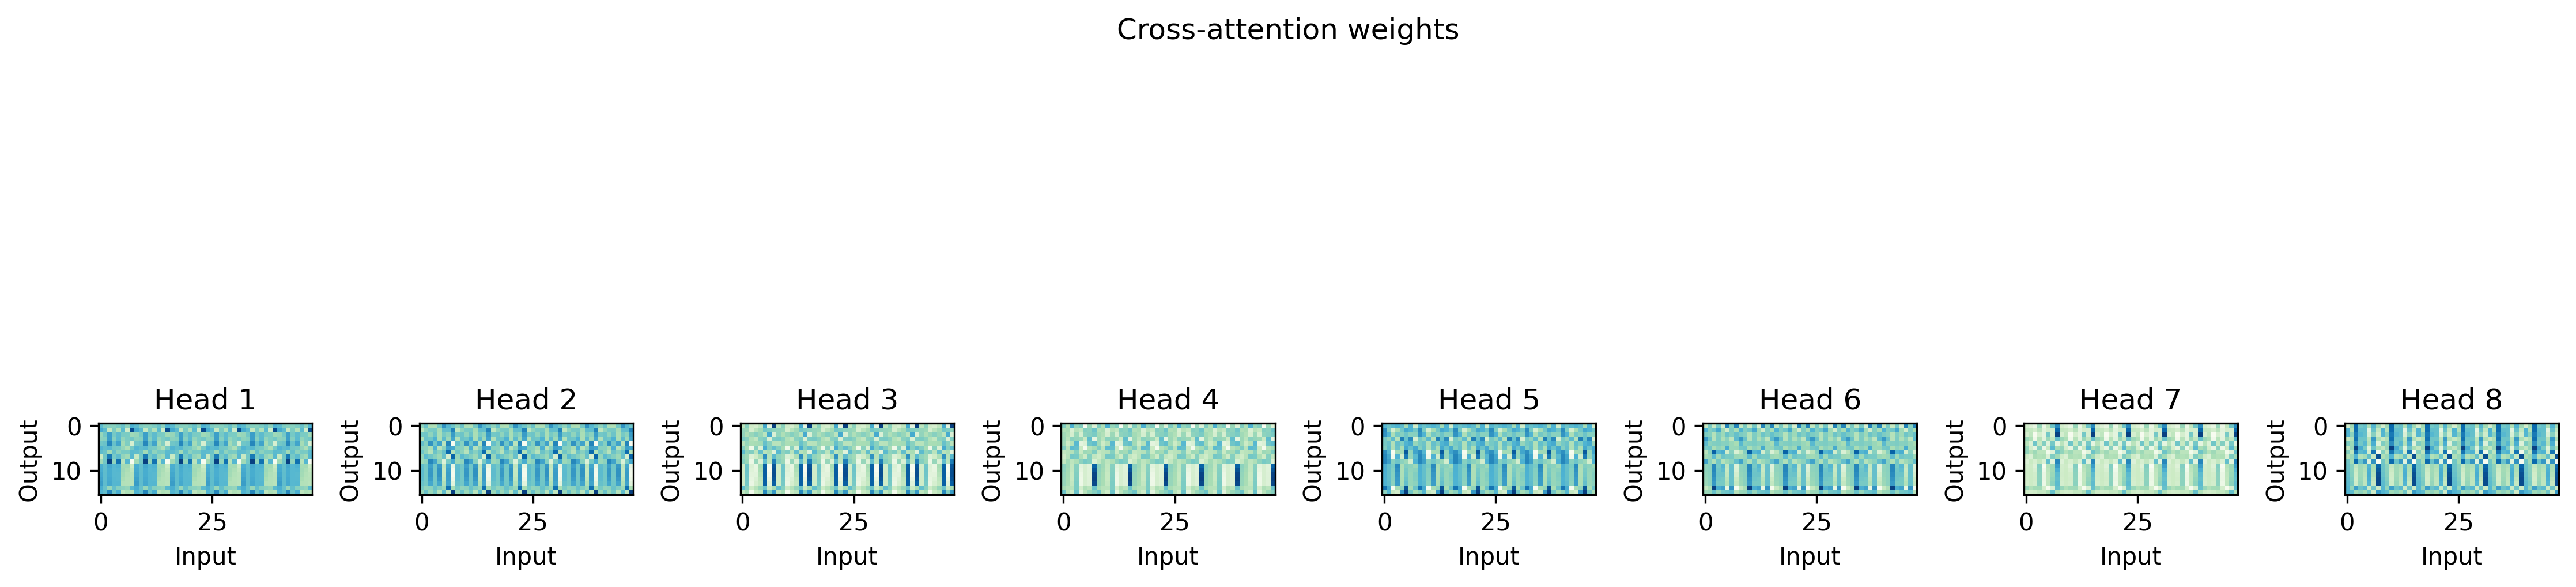

In [143]:
plot_attention(cross_attn_ws)